In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

from brevitas.export import export_onnx_qcdq

import torchmetrics

import cv2

import config_aimet
import dataset_dfire
import datasets_aimet
import models_aimet_medium_fasdd
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Define Matplotlib Style

In [3]:
#mpl.style.use('seaborn-v0_8')

# Logger

In [4]:
log_path = config_aimet.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tModels imported after AIMET processing.\n' +
            '\t\tPruning after SVD.\n' +
            '\t\tSVD after Pruning.\n' +
            '\tBrevitas with All Layers defined in the Model, but Dropout and Flatten.\n' +
            '\tBit width of Big Layers separated.\n' +
            '\tQuantIdentity with Uint8Act added and constant scale factor.\n' +
            '\tWeights with Per Channel Quant.\n' +
            '\tIntBias, Internal Scale with FixedPoint.\n' +
            '\tConv341 defined as big layer.\n' +
            '\tFASDD VAL added to train.\n' +
            f'\tFixed Point: {config_aimet.FIXED_POINT}.\n' +
            f'\tWeights bit width = {config_aimet.WEIGHTS_BIT_WIDTH}.\n' +
            f'\tBig Layers Weights bit width = {config_aimet.BIG_LAYERS_WEIGHTS_BIT_WIDTH}.\n' +
            f'\tActivations bit width = {config_aimet.ACTIVATIONS_BIT_WIDTH}.\n' +
            f'\tBias bit width = {config_aimet.BIAS_BIT_WIDTH}.\n' +
            f'\t{config_aimet.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [5]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config_aimet.IMG_H, config_aimet.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [6]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset_dfire.DFireDataset(
    img_h=config_aimet.IMG_H, 
    img_w=config_aimet.IMG_W, 
    img_dir=config_aimet.val_imgs, 
    label_dir=config_aimet.val_labels, 
    num_classes=config_aimet.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

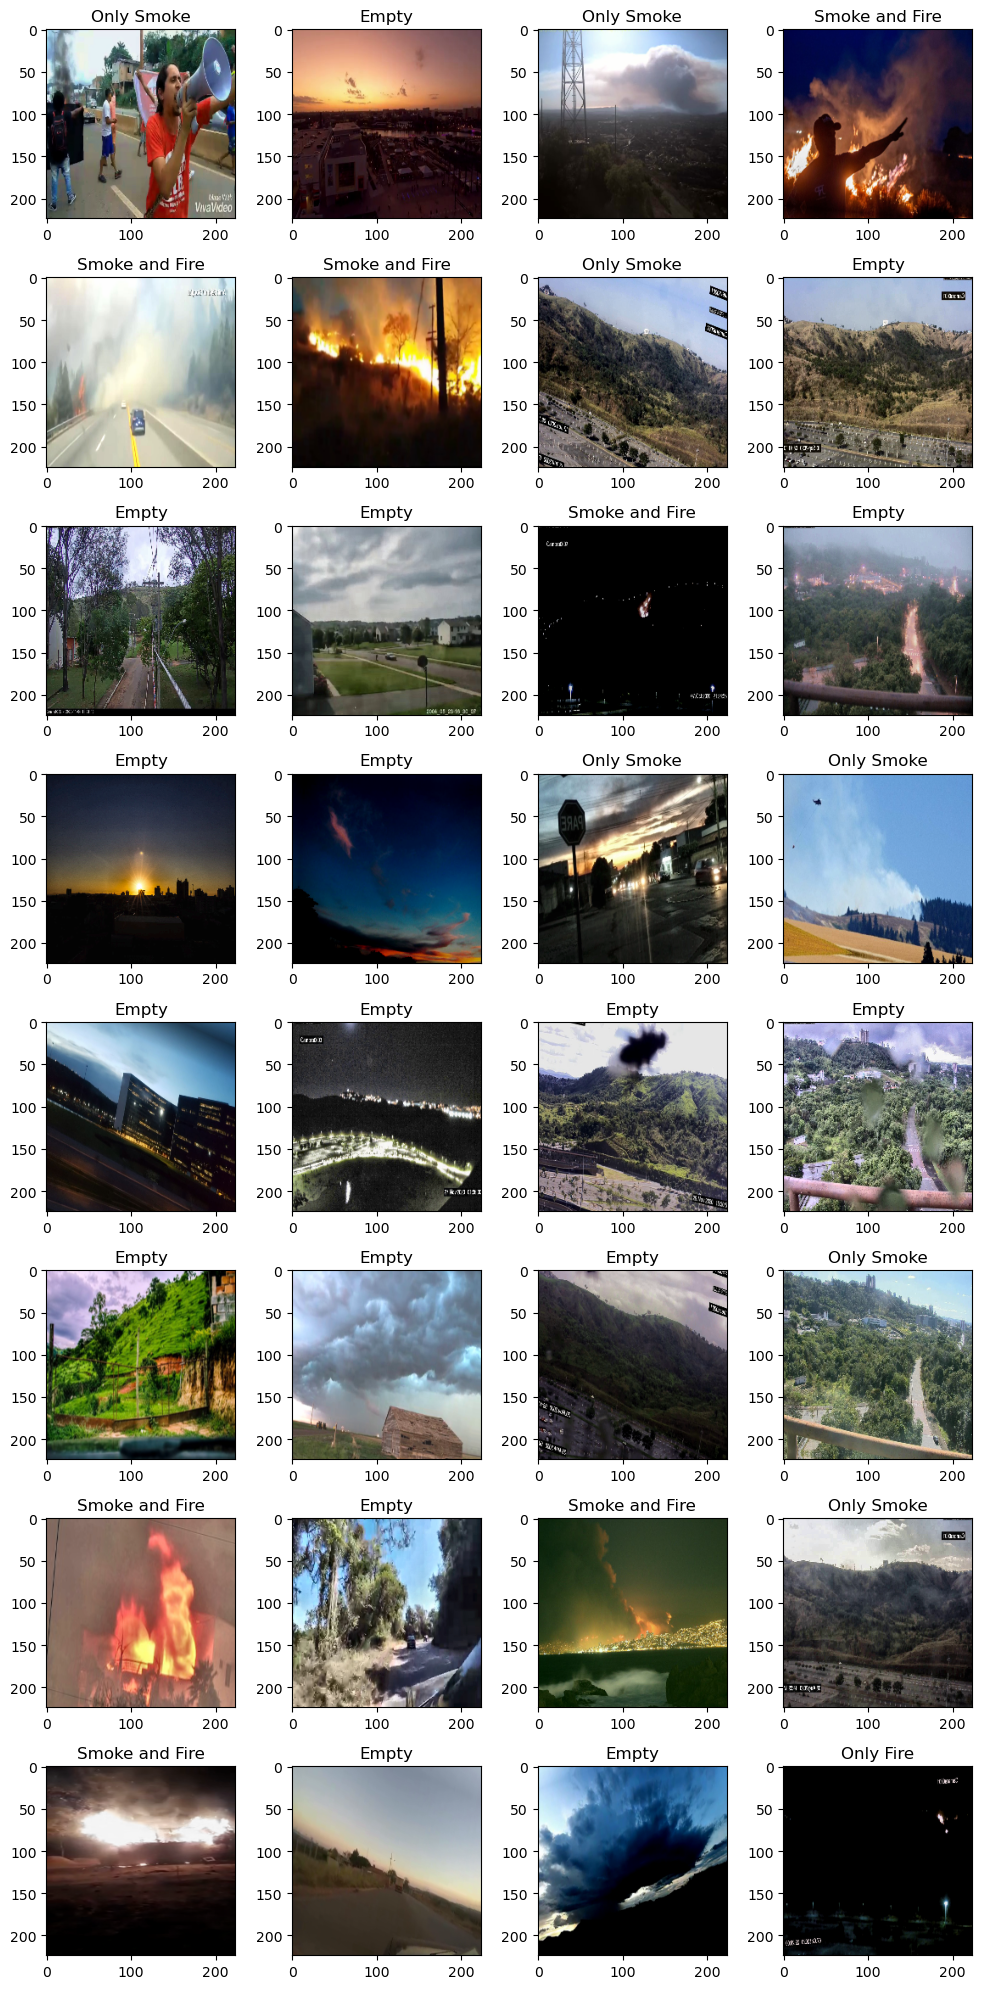

In [7]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [8]:
train_loader = datasets_aimet.get_train_loader()
val_loader = datasets_aimet.get_val_loader()


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763

Train DFire dataset len: 17221

TRAIN FASDD UAV dataset
FASDD Removed wrong images: 0
FASDD empty images: 5994
FASDD only smoke images: 2541
FASDD only fire images: 105
FASDD smoke and fire images: 3911

Train FASDD UAV dataset len: 12551

VAL FASDD UAV dataset
FASDD Removed wrong images: 0
FASDD empty images: 3995
FASDD only smoke images: 1693
FASDD only fire images: 70
FASDD smoke and fire images: 2607

Val FASDD UAV dataset len: 8365

TRAIN FASDD CV dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


FASDD Removed wrong images: 0
FASDD empty images: 19600
FASDD only smoke images: 11708
FASDD only fire images: 6276
FASDD smoke and fire images: 10076

Train FASDD CV dataset len: 47660

Val FASDD CV dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


FASDD Removed wrong images: 0
FASDD empty images: 13066
FASDD only smoke images: 7804
FASDD only fire images: 4183
FASDD smoke and fire images: 6717

Val FASDD CV dataset len: 31770

Concatenate Train DFire and Train FASDD UAV datasets
Train dataset len: 29772
Concatenate with Val FASDD UAV dataset
Train dataset len: 38137
Concatenate with Train FASDD CV dataset
Train dataset len: 85797
Concatenate with Val FASDD CV dataset
Train dataset len: 117567

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306

TEST FASDD UAV dataset
FASDD Removed wrong images: 0
FASDD empty images: 1997
FASDD only smoke images: 846
FASDD only fire images: 35
FASDD smoke and fire images: 1303

Test FASDD UAV dataset len: 4181

TEST FASDD CV dataset
FASDD Removed wrong images: 0
FASDD empty images: 6533
FASDD only smoke images: 3902
FASDD only fire images: 2091
FASDD smoke and 

# Models Setup

In [9]:
if config_aimet.MODEL == "BED":
    
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models_aimet_medium_fasdd.ORIGINAL_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)  
    
    print("Using Fixed Point Quantizers without BN")
    logger.info("Using Fixed Point Quantizers without BN")
    quant_model = models_aimet_medium_fasdd.QUANT_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(
            weight_bw = config_aimet.WEIGHTS_BIT_WIDTH,
            big_layers_weight_bw = config_aimet.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
            act_bw = config_aimet.ACTIVATIONS_BIT_WIDTH,
            bias_bw = config_aimet.BIAS_BIT_WIDTH,
            num_classes=config_aimet.N_CLASSES).to(config_aimet.DEVICE)

else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(quant_model.parameters(), 
                       lr=config_aimet.LEARNING_RATE, 
                       weight_decay=config_aimet.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config_aimet.FACTOR, 
                                                 patience=config_aimet.PATIENCE, 
                                                 threshold=config_aimet.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config_aimet.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in quant_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(quant_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Using Fixed Point Quantizers without BN

Trainable parameters = 63631
Total parameters = 63631



### Check Model Shape

In [10]:
in_rand_np = np.random.rand(4, 3, config_aimet.IMG_H, config_aimet.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config_aimet.DEVICE)
out_test = quant_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{quant_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{quant_model}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[ 0.0843, -0.0942],
        [ 0.0854, -0.0775],
        [ 0.0768, -0.0927],
        [ 0.0904, -0.0716]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
QUANT_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER(
  (model): Sequential(
    (input0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ConstScaling(
              (restrict_clamp_scaling): _RestrictClampValue(
              

# Load Pretrained or Initialize Weights

In [11]:
fp32_optimizer = optim.Adam(
    fp32_model.parameters(), 
    lr=config_aimet.LEARNING_RATE, 
    weight_decay=config_aimet.WEIGHT_DECAY)

fp32_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fp32_optimizer, 
    mode='min',
    factor=config_aimet.FACTOR, 
    patience=config_aimet.PATIENCE, 
    threshold=config_aimet.THRES, 
    threshold_mode='abs',
    min_lr=config_aimet.MIN_LR)

if config_aimet.LOAD_MODEL == False:
    if config_aimet.MODEL == "BED":
        fp32_model.__initialize_weights__()
        print("Initializing Weights")
        logger.info("Initializing Weights")
else:
    epochs_trained = utils.load_checkpoint(config_aimet.LOAD_MODEL_FILE, fp32_model, fp32_optimizer, fp32_scheduler, config_aimet.DEVICE)
    logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 6 epochs


# FP32 Original Model Baseline Evaluation

In [12]:
def evaluate_model(model, iterations, use_cuda):
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(val_loader):
            if use_cuda == True:
                x, y = x.to('cuda'), y.to('cuda')
            else:
                model.to('cpu')
            out = model(x)
            if iterations is not None:
                if batch_idx == iterations:
                    break
            
            # F1 average Macro   
            yhat = torch.sigmoid(out.detach())
            metrics.precision_metric.update(yhat, y)
            metrics.recall_metric.update(yhat, y)
            metrics.accuracy_metric.update(yhat, y)
            metrics.f1_metric.update(yhat, y)
            metrics.f1_metric_mean.update(yhat, y)
    
        precision = metrics.precision_metric.compute()
        recall = metrics.recall_metric.compute()
        accuracy = metrics.accuracy_metric.compute()
        f1 = metrics.f1_metric.compute()
        f1_mean = metrics.f1_metric_mean.compute()
        
        metrics.precision_metric.reset()
        metrics.recall_metric.reset()
        metrics.accuracy_metric.reset()
        metrics.f1_metric.reset()
        metrics.f1_metric_mean.reset()

        print(f'Precision -> smoke: {precision[0]:.4f} - fire: {precision[1]:.4f}')
        print(f'Recall: -> smoke: {recall[0]:.4f} - fire: {recall[1]:.4f}')
        print(f'Accuracy: -> smoke: {accuracy[0]:.4f} - fire: {accuracy[1]:.4f}')
        print(f'F1: -> smoke: {f1[0]:.4f} - fire: {f1[1]:.4f}')
        print(f'F1 mean: {f1_mean:.4f}')
    
    return f1_mean.item()

In [13]:
baseline_F1_mean = evaluate_model(fp32_model, None, True)
logger.info(f'Baseline F1 mean of original model: {baseline_F1_mean}')

Precision -> smoke: 0.9393 - fire: 0.9085
Recall: -> smoke: 0.8860 - fire: 0.9772
Accuracy: -> smoke: 0.9192 - fire: 0.9607
F1: -> smoke: 0.9118 - fire: 0.9416
F1 mean: 0.9267


# Torchinfo: model summary

### Quant Model

In [14]:
print(summary(quant_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
logger.info("Quant Model Summary")
logger.info(summary(quant_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))

Layer (type:depth-idx)                                                           Output Shape              Param #
QUANT_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER                                        [1, 2]                    --
├─Sequential: 1-1                                                                [1, 2]                    --
│    └─QuantIdentity: 2-1                                                        [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-1                                       [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-2                                       [1, 3, 224, 224]          --
│    └─QuantReLU: 2-55                                                           --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-89                                      --                        (recursive)
│    └─QuantIdentity: 2-3                                                        --              

### FP32 Model

In [15]:
fp32_model.eval()
print(summary(fp32_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
# print(summary(fp32_model, input_size=(config_aimet.BATCH_SIZE, 3, config_aimet.IMG_H, config_aimet.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(1, 3, config_aimet.IMG_H, config_aimet.IMG_W)))

Layer (type:depth-idx)                        Output Shape              Param #
ORIGINAL_MEDIUM_PRUNING_AFTER_SVD_CLASSIFIER  [1, 2]                    --
├─Sequential: 1-1                             [1, 2]                    --
│    └─Conv2d: 2-1                            [1, 32, 224, 224]         896
│    └─ReLU: 2-2                              [1, 32, 224, 224]         --
│    └─Dropout2d: 2-3                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                         [1, 32, 112, 112]         --
│    └─Sequential: 2-5                        [1, 14, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 19, 112, 112]         1,824
│    │    └─Conv2d: 3-2                       [1, 14, 112, 112]         812
│    └─ReLU: 2-6                              [1, 14, 112, 112]         --
│    └─Dropout2d: 2-7                         [1, 14, 112, 112]         --
│    └─MaxPool2d: 2-8                         [1, 14, 56, 56]           --
│    └─Sequenti

# Load Pretrained Weights from FP32 Model to Quant Model

In [16]:
# # Try to load fp32 weights to quant_model
from brevitas import config as brevitas_config

brevitas_config.IGNORE_MISSING_KEYS = True

### Load all Pretrained Weights

In [17]:
for fp32_name, fp32_mod in fp32_model.named_modules():
    for quant_name, quant_mod in  quant_model.named_modules():
        if fp32_name == quant_name:
            print(f'fp32 model name: {fp32_name} - quant model name: {quant_name}')
            if isinstance(fp32_mod, nn.Conv2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Conv2d layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.Linear):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Linear layer fp32 {fp32_name} into quant {quant_name}')
            else:
                print(f'\t______ Ignore weights or params of layer fp32 {fp32_name} and quant {quant_name}')

fp32 model name:  - quant model name: 
	______ Ignore weights or params of layer fp32  and quant 
fp32 model name: model - quant model name: model
	______ Ignore weights or params of layer fp32 model and quant model
fp32 model name: model.conv1 - quant model name: model.conv1
	****** Loading weights of Conv2d layer fp32 model.conv1 into quant model.conv1
fp32 model name: model.relu1 - quant model name: model.relu1
	______ Ignore weights or params of layer fp32 model.relu1 and quant model.relu1
fp32 model name: model.dropout1 - quant model name: model.dropout1
	______ Ignore weights or params of layer fp32 model.dropout1 and quant model.dropout1
fp32 model name: model.maxpool2 - quant model name: model.maxpool2
	______ Ignore weights or params of layer fp32 model.maxpool2 and quant model.maxpool2
fp32 model name: model.conv2 - quant model name: model.conv2
	______ Ignore weights or params of layer fp32 model.conv2 and quant model.conv2
fp32 model name: model.conv2.0 - quant model name: 

# Loss Function

In [18]:
if config_aimet.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config_aimet.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config_aimet.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config_aimet.DEVICE, smoke_precision_weight=config_aimet.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [19]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config_aimet.DEVICE}')
print(f'Learning Rate: {config_aimet.LEARNING_RATE}')
print(f'Weight Decay: {config_aimet.WEIGHT_DECAY}')
print(f'Batch Size: {config_aimet.BATCH_SIZE}')
print(f'IMG DIMS: ({config_aimet.IMG_H}, {config_aimet.IMG_W})')

logger.info(f'\nDevice: {config_aimet.DEVICE}')
logger.info(f'Learning Rate: {config_aimet.LEARNING_RATE}')
logger.info(f'Weight Decay: {config_aimet.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config_aimet.FACTOR}')
logger.info(f'Scheduler patience: {config_aimet.PATIENCE}')
logger.info(f'Scheduler threshold: {config_aimet.THRES}')
logger.info(f'Scheduler min learning rate: {config_aimet.MIN_LR}')
logger.info(f'Batch Size: {config_aimet.BATCH_SIZE}')
logger.info(f'W: {config_aimet.IMG_W}\nH: {config_aimet.IMG_H}')
logger.info(f'Batch Size: {config_aimet.BATCH_SIZE}')
logger.info(f'W: {config_aimet.IMG_W}\nH: {config_aimet.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [20]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config_aimet.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config_aimet.PLOTS_FOLDER, model_name=config_aimet.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config_aimet.PLOTS_FOLDER, model_name=config_aimet.MODEL, loss_or_metric='Metric')

# Main Function

In [21]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.89 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config_aimet.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config_aimet.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config_aimet.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config_aimet.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config_aimet.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.89
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.88
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.88 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.88")
            logger.info("Saving model with precision > 0.9 and recall > 0.88")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config_aimet.WEIGHTS_FOLDER + 'last_' + config_aimet.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [22]:
if __name__ == "__main__":
    
    print("Starting script\n")
    logger.info("Starting script\n")
    
    qnn_model = train_loop(model=quant_model)

Starting script


***Start Training: 00:10:03


=== EPOCH 0/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [08:07<00:00,  3.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.280      |16.402      |10.878      



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.779      |16.792      |11.987      
SMOKE -> Precision: 0.841 - Recall: 0.907 - Accuracy: 0.875 - F1: 0.873
FIRE -> Precision: 0.831 - Recall: 0.981 - Accuracy: 0.929 - F1: 0.900

Saving model with new best validation loss: 28.779
Saving model with best Mean F1: 0.8863

=== EPOCH 1/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.968      |14.591      |9.377       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.826      |15.448      |10.378      
SMOKE -> Precision: 0.880 - Recall: 0.876 - Accuracy: 0.885 - F1: 0.878
FIRE -> Precision: 0.856 - Recall: 0.967 - Accuracy: 0.937 - F1: 0.908

Saving model with new best validation loss: 25.826
Saving model with best Mean F1: 0.8931

=== EPOCH 2/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.282      |14.231      |9.050       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.122      |13.783      |10.339      
SMOKE -> Precision: 0.943 - Recall: 0.830 - Accuracy: 0.896 - F1: 0.883
FIRE -> Precision: 0.846 - Recall: 0.982 - Accuracy: 0.936 - F1: 0.909

Saving model with new best validation loss: 24.122
Saving model with best Mean F1: 0.8960

=== EPOCH 3/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.874      |13.940      |8.935       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.404      |12.064      |6.340       
SMOKE -> Precision: 0.942 - Recall: 0.864 - Accuracy: 0.910 - F1: 0.901
FIRE -> Precision: 0.933 - Recall: 0.950 - Accuracy: 0.962 - F1: 0.942

Saving model with new best validation loss: 18.404

Saving model with new best smoke precision: 0.942
Saving model with best Mean F1: 0.9213

=== EPOCH 4/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.753      |13.829      |8.924       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.081      |12.985      |7.096       
SMOKE -> Precision: 0.950 - Recall: 0.827 - Accuracy: 0.898 - F1: 0.884
FIRE -> Precision: 0.921 - Recall: 0.953 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 5/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.656      |13.816      |8.840       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.211      |14.443      |9.768       
SMOKE -> Precision: 0.900 - Recall: 0.888 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.870 - Recall: 0.972 - Accuracy: 0.944 - F1: 0.918

=== EPOCH 6/99 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.249      |13.644      |8.605       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.062      |13.186      |7.876       
SMOKE -> Precision: 0.934 - Recall: 0.864 - Accuracy: 0.907 - F1: 0.898
FIRE -> Precision: 0.884 - Recall: 0.974 - Accuracy: 0.950 - F1: 0.927

=== EPOCH 7/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.901      |13.349      |8.553       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.579      |12.620      |7.959       
SMOKE -> Precision: 0.922 - Recall: 0.889 - Accuracy: 0.912 - F1: 0.905
FIRE -> Precision: 0.888 - Recall: 0.979 - Accuracy: 0.953 - F1: 0.931

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 8/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.660      |13.166      |8.494       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.343      |12.381      |5.961       
SMOKE -> Precision: 0.929 - Recall: 0.879 - Accuracy: 0.912 - F1: 0.904
FIRE -> Precision: 0.940 - Recall: 0.954 - Accuracy: 0.965 - F1: 0.947

Saving model with new best validation loss: 18.343
Saving model with best Mean F1: 0.9254

=== EPOCH 9/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.566      |13.172      |8.394       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.080      |12.507      |7.573       
SMOKE -> Precision: 0.918 - Recall: 0.894 - Accuracy: 0.913 - F1: 0.906
FIRE -> Precision: 0.892 - Recall: 0.975 - Accuracy: 0.954 - F1: 0.932

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 10/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.510      |13.175      |8.335       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.616      |12.236      |7.380       
SMOKE -> Precision: 0.918 - Recall: 0.902 - Accuracy: 0.916 - F1: 0.910
FIRE -> Precision: 0.903 - Recall: 0.968 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 11/99 ===
Learning Rate = 8e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.658      |13.174      |8.484       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.533      |11.982      |8.551       
SMOKE -> Precision: 0.932 - Recall: 0.887 - Accuracy: 0.916 - F1: 0.909
FIRE -> Precision: 0.876 - Recall: 0.980 - Accuracy: 0.949 - F1: 0.925

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 12/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.138      |12.935      |8.204       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.961      |12.888      |8.073       
SMOKE -> Precision: 0.913 - Recall: 0.898 - Accuracy: 0.912 - F1: 0.905
FIRE -> Precision: 0.885 - Recall: 0.975 - Accuracy: 0.951 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 13/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.268      |13.038      |8.230       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.070      |12.502      |8.568       
SMOKE -> Precision: 0.946 - Recall: 0.863 - Accuracy: 0.912 - F1: 0.902
FIRE -> Precision: 0.877 - Recall: 0.977 - Accuracy: 0.948 - F1: 0.924

Saving model with new best smoke precision: 0.946

=== EPOCH 14/99 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.162      |12.993      |8.170       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.399      |12.588      |7.812       
SMOKE -> Precision: 0.941 - Recall: 0.853 - Accuracy: 0.905 - F1: 0.895
FIRE -> Precision: 0.893 - Recall: 0.973 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 15/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.965      |12.786      |8.179       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.607      |13.968      |7.638       
SMOKE -> Precision: 0.888 - Recall: 0.916 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.896 - Recall: 0.970 - Accuracy: 0.954 - F1: 0.932

=== EPOCH 16/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.974      |12.815      |8.159       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.519      |12.342      |9.177       
SMOKE -> Precision: 0.927 - Recall: 0.890 - Accuracy: 0.915 - F1: 0.908
FIRE -> Precision: 0.869 - Recall: 0.979 - Accuracy: 0.945 - F1: 0.920

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 17/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.868      |12.809      |8.059       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.870      |11.326      |6.543       
SMOKE -> Precision: 0.932 - Recall: 0.904 - Accuracy: 0.924 - F1: 0.918
FIRE -> Precision: 0.920 - Recall: 0.964 - Accuracy: 0.961 - F1: 0.941

Saving model with new best validation loss: 17.870

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9296

=== EPOCH 18/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.958      |12.799      |8.159       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.082      |12.477      |7.605       
SMOKE -> Precision: 0.942 - Recall: 0.861 - Accuracy: 0.909 - F1: 0.899
FIRE -> Precision: 0.896 - Recall: 0.976 - Accuracy: 0.955 - F1: 0.934

=== EPOCH 19/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.867      |12.737      |8.130       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.290      |12.247      |8.043       
SMOKE -> Precision: 0.914 - Recall: 0.906 - Accuracy: 0.916 - F1: 0.910
FIRE -> Precision: 0.885 - Recall: 0.977 - Accuracy: 0.951 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 20/99 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.965      |12.813      |8.152       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.438      |11.675      |8.763       
SMOKE -> Precision: 0.948 - Recall: 0.871 - Accuracy: 0.917 - F1: 0.908
FIRE -> Precision: 0.872 - Recall: 0.979 - Accuracy: 0.947 - F1: 0.922

Saving model with new best smoke precision: 0.948

=== EPOCH 21/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.617      |12.588      |8.029       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.294      |11.814      |7.479       
SMOKE -> Precision: 0.930 - Recall: 0.898 - Accuracy: 0.920 - F1: 0.914
FIRE -> Precision: 0.901 - Recall: 0.968 - Accuracy: 0.955 - F1: 0.934

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 22/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.574      |12.616      |7.957       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.148      |12.387      |7.761       
SMOKE -> Precision: 0.917 - Recall: 0.896 - Accuracy: 0.913 - F1: 0.906
FIRE -> Precision: 0.892 - Recall: 0.977 - Accuracy: 0.954 - F1: 0.933

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 23/99 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.384      |12.391      |7.993       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.412      |14.114      |8.298       
SMOKE -> Precision: 0.882 - Recall: 0.919 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.886 - Recall: 0.976 - Accuracy: 0.951 - F1: 0.929

=== EPOCH 24/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.345      |12.422      |7.923       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.355      |11.540      |6.814       
SMOKE -> Precision: 0.930 - Recall: 0.902 - Accuracy: 0.921 - F1: 0.915
FIRE -> Precision: 0.917 - Recall: 0.962 - Accuracy: 0.960 - F1: 0.939

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 25/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.185      |12.367      |7.818       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.198      |13.111      |8.087       
SMOKE -> Precision: 0.885 - Recall: 0.926 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.886 - Recall: 0.977 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 26/99 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.065      |12.249      |7.816       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.792      |13.255      |8.537       
SMOKE -> Precision: 0.913 - Recall: 0.892 - Accuracy: 0.909 - F1: 0.902
FIRE -> Precision: 0.878 - Recall: 0.979 - Accuracy: 0.949 - F1: 0.926

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 27/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.917      |12.119      |7.798       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.538      |12.191      |9.347       
SMOKE -> Precision: 0.925 - Recall: 0.894 - Accuracy: 0.916 - F1: 0.909
FIRE -> Precision: 0.863 - Recall: 0.984 - Accuracy: 0.944 - F1: 0.919

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 28/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.952      |12.256      |7.696       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.245      |12.942      |9.303       
SMOKE -> Precision: 0.894 - Recall: 0.926 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.870 - Recall: 0.982 - Accuracy: 0.947 - F1: 0.923

=== EPOCH 29/99 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.875      |12.130      |7.745       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.071      |12.433      |7.638       
SMOKE -> Precision: 0.913 - Recall: 0.892 - Accuracy: 0.909 - F1: 0.903
FIRE -> Precision: 0.895 - Recall: 0.975 - Accuracy: 0.955 - F1: 0.933

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 30/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.767      |12.128      |7.640       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.287      |12.110      |6.177       
SMOKE -> Precision: 0.908 - Recall: 0.917 - Accuracy: 0.917 - F1: 0.912
FIRE -> Precision: 0.936 - Recall: 0.950 - Accuracy: 0.963 - F1: 0.943

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 31/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.701      |12.020      |7.681       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.458      |12.121      |8.337       
SMOKE -> Precision: 0.910 - Recall: 0.913 - Accuracy: 0.916 - F1: 0.912
FIRE -> Precision: 0.876 - Recall: 0.985 - Accuracy: 0.950 - F1: 0.927

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 32/99 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.623      |11.972      |7.651       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.191      |12.058      |7.134       
SMOKE -> Precision: 0.916 - Recall: 0.911 - Accuracy: 0.919 - F1: 0.913
FIRE -> Precision: 0.899 - Recall: 0.978 - Accuracy: 0.957 - F1: 0.937

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 33/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.646      |12.036      |7.610       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.570      |12.469      |8.100       
SMOKE -> Precision: 0.912 - Recall: 0.904 - Accuracy: 0.914 - F1: 0.908
FIRE -> Precision: 0.881 - Recall: 0.982 - Accuracy: 0.951 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 34/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [06:14<00:00,  4.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.731      |12.097      |7.634       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [02:08<00:00,  2.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.643      |12.082      |6.561       
SMOKE -> Precision: 0.910 - Recall: 0.916 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.916 - Recall: 0.970 - Accuracy: 0.961 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 35/99 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [08:47<00:00,  3.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.635      |11.990      |7.644       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:33<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.006      |11.253      |7.754       
SMOKE -> Precision: 0.936 - Recall: 0.901 - Accuracy: 0.924 - F1: 0.918
FIRE -> Precision: 0.894 - Recall: 0.974 - Accuracy: 0.954 - F1: 0.932

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 36/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.370      |11.815      |7.555       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.185      |11.437      |8.748       
SMOKE -> Precision: 0.952 - Recall: 0.880 - Accuracy: 0.923 - F1: 0.915
FIRE -> Precision: 0.870 - Recall: 0.985 - Accuracy: 0.947 - F1: 0.924

Saving model with new best smoke precision: 0.952

=== EPOCH 37/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.540      |11.962      |7.577       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.923      |13.171      |9.752       
SMOKE -> Precision: 0.901 - Recall: 0.911 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.854 - Recall: 0.985 - Accuracy: 0.940 - F1: 0.915

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 38/99 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.508      |11.983      |7.525       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.933      |11.337      |6.596       
SMOKE -> Precision: 0.924 - Recall: 0.913 - Accuracy: 0.924 - F1: 0.919
FIRE -> Precision: 0.909 - Recall: 0.974 - Accuracy: 0.960 - F1: 0.941

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9297

=== EPOCH 39/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.435      |11.891      |7.544       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.086      |11.331      |7.755       
SMOKE -> Precision: 0.946 - Recall: 0.889 - Accuracy: 0.924 - F1: 0.917
FIRE -> Precision: 0.890 - Recall: 0.981 - Accuracy: 0.955 - F1: 0.933

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 40/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.470      |11.885      |7.586       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.996      |11.680      |6.316       
SMOKE -> Precision: 0.927 - Recall: 0.901 - Accuracy: 0.920 - F1: 0.914
FIRE -> Precision: 0.917 - Recall: 0.973 - Accuracy: 0.963 - F1: 0.944

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 41/99 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.354      |11.859      |7.495       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.344      |11.907      |7.437       
SMOKE -> Precision: 0.918 - Recall: 0.905 - Accuracy: 0.917 - F1: 0.912
FIRE -> Precision: 0.895 - Recall: 0.976 - Accuracy: 0.955 - F1: 0.934

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 42/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.280      |11.636      |7.644       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.219      |12.252      |7.967       
SMOKE -> Precision: 0.920 - Recall: 0.898 - Accuracy: 0.915 - F1: 0.909
FIRE -> Precision: 0.886 - Recall: 0.980 - Accuracy: 0.953 - F1: 0.931

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 43/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.261      |11.835      |7.427       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.241      |12.120      |8.121       
SMOKE -> Precision: 0.909 - Recall: 0.919 - Accuracy: 0.919 - F1: 0.914
FIRE -> Precision: 0.883 - Recall: 0.979 - Accuracy: 0.951 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 44/99 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.318      |11.760      |7.558       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.570      |11.811      |6.759       
SMOKE -> Precision: 0.909 - Recall: 0.924 - Accuracy: 0.921 - F1: 0.917
FIRE -> Precision: 0.909 - Recall: 0.970 - Accuracy: 0.959 - F1: 0.939

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 45/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.375      |11.778      |7.597       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.472      |10.815      |5.657       
SMOKE -> Precision: 0.952 - Recall: 0.884 - Accuracy: 0.924 - F1: 0.917
FIRE -> Precision: 0.940 - Recall: 0.958 - Accuracy: 0.966 - F1: 0.949

Saving model with new best validation loss: 16.472

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9326

=== EPOCH 46/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.330      |11.816      |7.513       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.630      |12.371      |7.259       
SMOKE -> Precision: 0.905 - Recall: 0.918 - Accuracy: 0.916 - F1: 0.911
FIRE -> Precision: 0.894 - Recall: 0.982 - Accuracy: 0.956 - F1: 0.936

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 47/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.366      |11.828      |7.538       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.588      |12.117      |10.472      
SMOKE -> Precision: 0.922 - Recall: 0.905 - Accuracy: 0.919 - F1: 0.913
FIRE -> Precision: 0.856 - Recall: 0.982 - Accuracy: 0.941 - F1: 0.915

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 48/99 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.326      |11.835      |7.492       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.201      |12.556      |11.645      
SMOKE -> Precision: 0.910 - Recall: 0.911 - Accuracy: 0.916 - F1: 0.911
FIRE -> Precision: 0.826 - Recall: 0.990 - Accuracy: 0.929 - F1: 0.901

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 49/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.169      |11.707      |7.462       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.710      |11.278      |7.432       
SMOKE -> Precision: 0.935 - Recall: 0.904 - Accuracy: 0.925 - F1: 0.919
FIRE -> Precision: 0.893 - Recall: 0.980 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 50/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.304      |11.799      |7.505       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.683      |12.150      |7.532       
SMOKE -> Precision: 0.922 - Recall: 0.904 - Accuracy: 0.919 - F1: 0.913
FIRE -> Precision: 0.892 - Recall: 0.980 - Accuracy: 0.955 - F1: 0.934

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 51/99 ===
Learning Rate = 5.4975581388800055e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.150      |11.714      |7.436       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.956      |10.956      |7.000       
SMOKE -> Precision: 0.942 - Recall: 0.900 - Accuracy: 0.927 - F1: 0.921
FIRE -> Precision: 0.904 - Recall: 0.975 - Accuracy: 0.959 - F1: 0.938

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 52/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.058      |11.623      |7.435       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.256      |11.705      |9.551       
SMOKE -> Precision: 0.937 - Recall: 0.888 - Accuracy: 0.919 - F1: 0.912
FIRE -> Precision: 0.862 - Recall: 0.986 - Accuracy: 0.944 - F1: 0.920

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 53/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.114      |11.654      |7.460       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.206      |11.742      |6.465       
SMOKE -> Precision: 0.953 - Recall: 0.865 - Accuracy: 0.916 - F1: 0.907
FIRE -> Precision: 0.915 - Recall: 0.975 - Accuracy: 0.962 - F1: 0.944

Saving model with new best smoke precision: 0.953

=== EPOCH 54/99 ===
Learning Rate = 4.3980465111040045e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.205      |11.774      |7.431       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.328      |11.993      |9.335       
SMOKE -> Precision: 0.913 - Recall: 0.916 - Accuracy: 0.919 - F1: 0.914
FIRE -> Precision: 0.861 - Recall: 0.987 - Accuracy: 0.944 - F1: 0.920

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 55/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.068      |11.653      |7.415       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.143      |10.835      |6.308       
SMOKE -> Precision: 0.940 - Recall: 0.896 - Accuracy: 0.924 - F1: 0.918
FIRE -> Precision: 0.919 - Recall: 0.969 - Accuracy: 0.962 - F1: 0.943

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 56/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.995      |11.675      |7.320       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.221      |10.820      |6.401       
SMOKE -> Precision: 0.947 - Recall: 0.893 - Accuracy: 0.926 - F1: 0.919
FIRE -> Precision: 0.919 - Recall: 0.971 - Accuracy: 0.963 - F1: 0.944

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 57/99 ===
Learning Rate = 3.5184372088832037e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.969      |11.587      |7.382       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.277      |10.749      |7.528       
SMOKE -> Precision: 0.937 - Recall: 0.905 - Accuracy: 0.926 - F1: 0.921
FIRE -> Precision: 0.895 - Recall: 0.978 - Accuracy: 0.955 - F1: 0.934

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 58/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.000      |11.601      |7.399       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.773      |11.225      |6.548       
SMOKE -> Precision: 0.942 - Recall: 0.894 - Accuracy: 0.924 - F1: 0.918
FIRE -> Precision: 0.912 - Recall: 0.974 - Accuracy: 0.961 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 59/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.913      |11.553      |7.359       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.576      |11.060      |5.516       
SMOKE -> Precision: 0.952 - Recall: 0.883 - Accuracy: 0.924 - F1: 0.916
FIRE -> Precision: 0.942 - Recall: 0.958 - Accuracy: 0.967 - F1: 0.950

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9329

=== EPOCH 60/99 ===
Learning Rate = 2.8147497671065632e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.025      |11.593      |7.432       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.979      |11.247      |7.732       
SMOKE -> Precision: 0.934 - Recall: 0.898 - Accuracy: 0.922 - F1: 0.916
FIRE -> Precision: 0.895 - Recall: 0.979 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 61/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.830      |11.426      |7.404       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.222      |11.316      |7.906       
SMOKE -> Precision: 0.924 - Recall: 0.915 - Accuracy: 0.925 - F1: 0.920
FIRE -> Precision: 0.888 - Recall: 0.981 - Accuracy: 0.954 - F1: 0.932

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 62/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.743      |11.479      |7.265       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.956      |11.404      |7.552       
SMOKE -> Precision: 0.933 - Recall: 0.900 - Accuracy: 0.923 - F1: 0.916
FIRE -> Precision: 0.896 - Recall: 0.976 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 63/99 ===
Learning Rate = 2.2517998136852508e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.918      |11.608      |7.310       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.185      |11.527      |6.658       
SMOKE -> Precision: 0.923 - Recall: 0.908 - Accuracy: 0.921 - F1: 0.915
FIRE -> Precision: 0.909 - Recall: 0.977 - Accuracy: 0.961 - F1: 0.942

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 64/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.682      |11.389      |7.292       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.590      |11.401      |6.189       
SMOKE -> Precision: 0.948 - Recall: 0.884 - Accuracy: 0.922 - F1: 0.915
FIRE -> Precision: 0.918 - Recall: 0.975 - Accuracy: 0.963 - F1: 0.945

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 65/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.868      |11.502      |7.366       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.656      |10.671      |5.985       
SMOKE -> Precision: 0.961 - Recall: 0.876 - Accuracy: 0.925 - F1: 0.917
FIRE -> Precision: 0.925 - Recall: 0.968 - Accuracy: 0.964 - F1: 0.946

Saving model with new best smoke precision: 0.961

=== EPOCH 66/99 ===
Learning Rate = 1.8014398509482006e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.934      |11.502      |7.432       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.419      |10.861      |7.558       
SMOKE -> Precision: 0.930 - Recall: 0.909 - Accuracy: 0.925 - F1: 0.919
FIRE -> Precision: 0.898 - Recall: 0.977 - Accuracy: 0.957 - F1: 0.936

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 67/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.892      |11.513      |7.379       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.161      |11.573      |7.587       
SMOKE -> Precision: 0.937 - Recall: 0.885 - Accuracy: 0.918 - F1: 0.911
FIRE -> Precision: 0.889 - Recall: 0.982 - Accuracy: 0.954 - F1: 0.933

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 68/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.880      |11.579      |7.301       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.723      |12.093      |9.630       
SMOKE -> Precision: 0.902 - Recall: 0.925 - Accuracy: 0.918 - F1: 0.914
FIRE -> Precision: 0.859 - Recall: 0.985 - Accuracy: 0.943 - F1: 0.918

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 69/99 ===
Learning Rate = 1.4411518807585606e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:04<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.830      |11.492      |7.338       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.634      |12.113      |7.521       
SMOKE -> Precision: 0.918 - Recall: 0.907 - Accuracy: 0.918 - F1: 0.913
FIRE -> Precision: 0.892 - Recall: 0.982 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 70/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.887      |11.518      |7.369       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.270      |12.604      |9.666       
SMOKE -> Precision: 0.909 - Recall: 0.910 - Accuracy: 0.915 - F1: 0.910
FIRE -> Precision: 0.862 - Recall: 0.981 - Accuracy: 0.943 - F1: 0.918

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 71/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.730      |11.404      |7.326       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.291      |14.878      |7.413       
SMOKE -> Precision: 0.864 - Recall: 0.938 - Accuracy: 0.901 - F1: 0.900
FIRE -> Precision: 0.896 - Recall: 0.977 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 72/99 ===
Learning Rate = 1.1529215046068486e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.910      |11.487      |7.423       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.980      |11.816      |8.164       
SMOKE -> Precision: 0.926 - Recall: 0.903 - Accuracy: 0.920 - F1: 0.914
FIRE -> Precision: 0.885 - Recall: 0.978 - Accuracy: 0.952 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 73/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.663      |11.438      |7.224       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.902      |11.129      |6.773       
SMOKE -> Precision: 0.923 - Recall: 0.916 - Accuracy: 0.924 - F1: 0.919
FIRE -> Precision: 0.905 - Recall: 0.980 - Accuracy: 0.960 - F1: 0.941

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 74/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.654      |11.326      |7.328       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.915      |12.526      |8.389       
SMOKE -> Precision: 0.930 - Recall: 0.877 - Accuracy: 0.911 - F1: 0.903
FIRE -> Precision: 0.886 - Recall: 0.977 - Accuracy: 0.952 - F1: 0.929

=== EPOCH 75/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.810      |11.451      |7.359       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.664      |11.156      |6.508       
SMOKE -> Precision: 0.926 - Recall: 0.915 - Accuracy: 0.925 - F1: 0.920
FIRE -> Precision: 0.908 - Recall: 0.977 - Accuracy: 0.960 - F1: 0.941

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 76/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.773      |11.501      |7.272       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.377      |11.113      |8.263       
SMOKE -> Precision: 0.930 - Recall: 0.912 - Accuracy: 0.926 - F1: 0.921
FIRE -> Precision: 0.880 - Recall: 0.984 - Accuracy: 0.952 - F1: 0.929

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 77/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.481      |11.294      |7.187       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.763      |11.987      |7.776       
SMOKE -> Precision: 0.907 - Recall: 0.926 - Accuracy: 0.920 - F1: 0.916
FIRE -> Precision: 0.889 - Recall: 0.980 - Accuracy: 0.954 - F1: 0.933

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 78/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.682      |11.381      |7.300       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.704      |10.801      |5.903       
SMOKE -> Precision: 0.948 - Recall: 0.897 - Accuracy: 0.928 - F1: 0.921
FIRE -> Precision: 0.923 - Recall: 0.972 - Accuracy: 0.965 - F1: 0.947

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9340

=== EPOCH 79/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.674      |11.442      |7.232       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.666      |11.179      |7.487       
SMOKE -> Precision: 0.921 - Recall: 0.917 - Accuracy: 0.924 - F1: 0.919
FIRE -> Precision: 0.893 - Recall: 0.981 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 80/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.783      |11.486      |7.297       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.677      |11.225      |7.452       
SMOKE -> Precision: 0.935 - Recall: 0.903 - Accuracy: 0.925 - F1: 0.919
FIRE -> Precision: 0.895 - Recall: 0.980 - Accuracy: 0.956 - F1: 0.936

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 81/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.722      |11.406      |7.317       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.638      |11.189      |7.448       
SMOKE -> Precision: 0.933 - Recall: 0.907 - Accuracy: 0.925 - F1: 0.920
FIRE -> Precision: 0.896 - Recall: 0.979 - Accuracy: 0.956 - F1: 0.936

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 82/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.713      |11.387      |7.327       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.357      |12.411      |8.946       
SMOKE -> Precision: 0.908 - Recall: 0.916 - Accuracy: 0.916 - F1: 0.912
FIRE -> Precision: 0.870 - Recall: 0.983 - Accuracy: 0.947 - F1: 0.923

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 83/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.724      |11.455      |7.268       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.991      |11.999      |8.992       
SMOKE -> Precision: 0.910 - Recall: 0.920 - Accuracy: 0.919 - F1: 0.915
FIRE -> Precision: 0.872 - Recall: 0.979 - Accuracy: 0.947 - F1: 0.922

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 84/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.671      |11.399      |7.272       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.787      |11.775      |7.012       
SMOKE -> Precision: 0.914 - Recall: 0.919 - Accuracy: 0.921 - F1: 0.917
FIRE -> Precision: 0.898 - Recall: 0.979 - Accuracy: 0.957 - F1: 0.937

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 85/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.778      |11.494      |7.284       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.122      |12.262      |6.860       
SMOKE -> Precision: 0.907 - Recall: 0.927 - Accuracy: 0.921 - F1: 0.917
FIRE -> Precision: 0.906 - Recall: 0.976 - Accuracy: 0.959 - F1: 0.940

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 86/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.846      |11.540      |7.306       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.728      |10.831      |6.897       
SMOKE -> Precision: 0.937 - Recall: 0.902 - Accuracy: 0.925 - F1: 0.919
FIRE -> Precision: 0.911 - Recall: 0.969 - Accuracy: 0.959 - F1: 0.939

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 87/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.880      |11.596      |7.285       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.549      |10.870      |6.679       
SMOKE -> Precision: 0.933 - Recall: 0.907 - Accuracy: 0.925 - F1: 0.920
FIRE -> Precision: 0.906 - Recall: 0.978 - Accuracy: 0.960 - F1: 0.941

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 88/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.762      |11.500      |7.262       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.133      |10.952      |9.182       
SMOKE -> Precision: 0.932 - Recall: 0.906 - Accuracy: 0.924 - F1: 0.918
FIRE -> Precision: 0.865 - Recall: 0.985 - Accuracy: 0.946 - F1: 0.921

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 89/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:05<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.915      |11.554      |7.361       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.821      |11.181      |5.640       
SMOKE -> Precision: 0.929 - Recall: 0.909 - Accuracy: 0.924 - F1: 0.919
FIRE -> Precision: 0.930 - Recall: 0.969 - Accuracy: 0.967 - F1: 0.950

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9343

=== EPOCH 90/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.817      |11.485      |7.332       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.786      |10.705      |6.081       
SMOKE -> Precision: 0.943 - Recall: 0.898 - Accuracy: 0.926 - F1: 0.920
FIRE -> Precision: 0.924 - Recall: 0.970 - Accuracy: 0.965 - F1: 0.947

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 91/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:10<00:00,  5.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.727      |11.423      |7.304       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:35<00:00, 10.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.419      |12.159      |7.260       
SMOKE -> Precision: 0.904 - Recall: 0.930 - Accuracy: 0.920 - F1: 0.917
FIRE -> Precision: 0.899 - Recall: 0.974 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 92/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.871      |11.452      |7.418       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.036      |11.283      |6.754       
SMOKE -> Precision: 0.928 - Recall: 0.908 - Accuracy: 0.923 - F1: 0.918
FIRE -> Precision: 0.910 - Recall: 0.973 - Accuracy: 0.960 - F1: 0.940

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 93/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.740      |11.477      |7.263       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.472      |11.792      |7.679       
SMOKE -> Precision: 0.914 - Recall: 0.919 - Accuracy: 0.921 - F1: 0.917
FIRE -> Precision: 0.890 - Recall: 0.981 - Accuracy: 0.955 - F1: 0.933

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 94/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.806      |11.537      |7.269       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.312      |10.550      |5.762       
SMOKE -> Precision: 0.950 - Recall: 0.897 - Accuracy: 0.929 - F1: 0.923
FIRE -> Precision: 0.926 - Recall: 0.974 - Accuracy: 0.966 - F1: 0.950

Saving model with new best validation loss: 16.312

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9362

=== EPOCH 95/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:09<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.923      |11.580      |7.343       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.865      |11.098      |7.767       
SMOKE -> Precision: 0.921 - Recall: 0.922 - Accuracy: 0.926 - F1: 0.922
FIRE -> Precision: 0.886 - Recall: 0.981 - Accuracy: 0.953 - F1: 0.932

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 96/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.903      |11.606      |7.298       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.269      |12.187      |9.082       
SMOKE -> Precision: 0.918 - Recall: 0.905 - Accuracy: 0.917 - F1: 0.911
FIRE -> Precision: 0.868 - Recall: 0.982 - Accuracy: 0.946 - F1: 0.921

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 97/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:08<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.999      |11.601      |7.398       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:35<00:00, 10.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.107      |11.364      |8.742       
SMOKE -> Precision: 0.922 - Recall: 0.912 - Accuracy: 0.922 - F1: 0.917
FIRE -> Precision: 0.878 - Recall: 0.979 - Accuracy: 0.949 - F1: 0.926

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 98/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:06<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.909      |11.604      |7.305       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.020      |10.617      |6.403       
SMOKE -> Precision: 0.939 - Recall: 0.908 - Accuracy: 0.929 - F1: 0.924
FIRE -> Precision: 0.917 - Recall: 0.974 - Accuracy: 0.963 - F1: 0.945

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 99/99 ===
Learning Rate = 1e-06



Training: 100%|██████████████████████████████████████████████████████████████████████████| 1836/1836 [05:07<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.844      |11.508      |7.336       



Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.103      |11.977      |7.126       
SMOKE -> Precision: 0.913 - Recall: 0.914 - Accuracy: 0.919 - F1: 0.914
FIRE -> Precision: 0.900 - Recall: 0.979 - Accuracy: 0.958 - F1: 0.938

Saving model with precision > 0.9 and recall > 0.88

***Script finished: 09:50:34

Time elapsed: 9:40:30.578101


# Export to ONNX

In [23]:
qnn_model.eval()
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
    export_path=config_aimet.RUN_FOLDER+'pretrained_qcdq.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


## CPU export

In [24]:
qnn_model.to('cpu')
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to('cpu'), 
    export_path=config_aimet.RUN_FOLDER+'pretrained_qcdq_cpu.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Loas Checkpoint

In [32]:
qnn_model.to(config_aimet.DEVICE)

weights_folder = './experiments_fuseBN_256_fasdd/test_v30_FASDD_VAL__MED_w4W3a8b4_FxdPnt_MSE_PerChnlW_IntBiasIntScl/weights/'
weights_file = weights_folder + 'BED_classifier__best_mean_F1.pt'

utils.load_checkpoint(
    model_path=weights_file,
    model=qnn_model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=config_aimet.DEVICE)

Loading Model. Trained during 94 epochs


94

# Eval Checkpoint

In [33]:
with torch.no_grad():
    val_losses, val_metrics = val_epoch.eval_fn(
        loader=val_loader, 
        model=qnn_model,                         
        loss_fn=loss_fn,
        device=config_aimet.DEVICE)

Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:41<00:00,  9.24it/s]

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.312      |10.550      |5.762       
SMOKE -> Precision: 0.950 - Recall: 0.897 - Accuracy: 0.929 - F1: 0.923
FIRE -> Precision: 0.926 - Recall: 0.974 - Accuracy: 0.966 - F1: 0.950


In [34]:
print(val_metrics)
print(f'Mean F1: {(val_metrics["F1"][0]+val_metrics["F1"][1])/2}')

{'Accuracy': [0.9291529655456543, 0.9664884805679321], 'Precision': [0.9498522281646729, 0.9262028336524963], 'Recall': [0.8970780372619629, 0.9742516279220581], 'F1': [0.922711193561554, 0.9496198296546936]}
Mean F1: 0.9361655116081238


## Check that qnn_model and quant_model are the same

In [35]:
with torch.no_grad():
    val_losses, val_metrics = val_epoch.eval_fn(
        loader=val_loader, 
        model=quant_model,                         
        loss_fn=loss_fn,
        device=config_aimet.DEVICE)

Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.10it/s]

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.312      |10.550      |5.762       
SMOKE -> Precision: 0.950 - Recall: 0.897 - Accuracy: 0.929 - F1: 0.923
FIRE -> Precision: 0.926 - Recall: 0.974 - Accuracy: 0.966 - F1: 0.950


In [36]:
print(val_metrics)
print(f'Mean F1: {(val_metrics["F1"][0]+val_metrics["F1"][1])/2}')

{'Accuracy': [0.9291529655456543, 0.9664884805679321], 'Precision': [0.9498522281646729, 0.9262028336524963], 'Recall': [0.8970780372619629, 0.9742516279220581], 'F1': [0.922711193561554, 0.9496198296546936]}
Mean F1: 0.9361655116081238


# Export to ONNX

In [37]:
qnn_model.to('cpu')
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to('cpu'), 
    export_path=config_aimet.RUN_FOLDER+'BED__med_comp__341_big__best_mean_f1__cpu.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Another Model

In [38]:
qnn_model.to(config_aimet.DEVICE)

weights_folder = './experiments_fuseBN_256_fasdd/test_v30_FASDD_VAL__MED_w4W3a8b4_FxdPnt_MSE_PerChnlW_IntBiasIntScl/weights/'
weights_file = weights_folder + 'BED_classifier__smoke__precision=0.9263__recall=0.9147__epoch=75.pt'

utils.load_checkpoint(
    model_path=weights_file,
    model=qnn_model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=config_aimet.DEVICE)

Loading Model. Trained during 75 epochs


75

In [39]:
with torch.no_grad():
    val_losses, val_metrics = val_epoch.eval_fn(
        loader=val_loader, 
        model=qnn_model,                         
        loss_fn=loss_fn,
        device=config_aimet.DEVICE)

Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.03it/s]

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.664      |11.156      |6.508       
SMOKE -> Precision: 0.926 - Recall: 0.915 - Accuracy: 0.925 - F1: 0.920
FIRE -> Precision: 0.908 - Recall: 0.977 - Accuracy: 0.960 - F1: 0.941


In [40]:
print(val_metrics)
print(f'Mean F1: {(val_metrics["F1"][0]+val_metrics["F1"][1])/2}')

{'Accuracy': [0.9254934191703796, 0.9604852199554443], 'Precision': [0.9263315796852112, 0.9082438945770264], 'Recall': [0.9146969318389893, 0.9767884612083435], 'F1': [0.9204775094985962, 0.9412699341773987]}
Mean F1: 0.9308737218379974


In [41]:
qnn_model.to('cpu')
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to('cpu'), 
    export_path=config_aimet.RUN_FOLDER+'BED__med_comp__341_big__precision=0.9263__recall=0.9147__epoch=75__cpu.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# One More, More Balanced with Smoke Precision and Recall

In [42]:
qnn_model.to(config_aimet.DEVICE)

weights_folder = './experiments_fuseBN_256_fasdd/test_v30_FASDD_VAL__MED_w4W3a8b4_FxdPnt_MSE_PerChnlW_IntBiasIntScl/weights/'
weights_file = weights_folder + 'BED_classifier__smoke__precision=0.9391__recall=0.9084__epoch=98.pt'

utils.load_checkpoint(
    model_path=weights_file,
    model=qnn_model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=config_aimet.DEVICE)

Loading Model. Trained during 98 epochs


98

In [43]:
with torch.no_grad():
    val_losses, val_metrics = val_epoch.eval_fn(
        loader=val_loader, 
        model=qnn_model,                         
        loss_fn=loss_fn,
        device=config_aimet.DEVICE)

Validating: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [00:34<00:00, 11.06it/s]

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.020      |10.617      |6.403       
SMOKE -> Precision: 0.939 - Recall: 0.908 - Accuracy: 0.929 - F1: 0.924
FIRE -> Precision: 0.917 - Recall: 0.974 - Accuracy: 0.963 - F1: 0.945


In [44]:
print(val_metrics)
print(f'Mean F1: {(val_metrics["F1"][0]+val_metrics["F1"][1])/2}')

{'Accuracy': [0.9290707111358643, 0.9629111886024475], 'Precision': [0.9391343593597412, 0.9168856143951416], 'Recall': [0.9084169268608093, 0.973871111869812], 'F1': [0.9235202670097351, 0.9445196390151978]}
Mean F1: 0.9340199530124664


In [45]:
qnn_model.to('cpu')
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to('cpu'), 
    export_path=config_aimet.RUN_FOLDER+'BED__med_comp__341_big__precision=0.9391__recall=0.9084__epoch=98__cpu.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Another ONNX Export option

In [29]:
# from brevitas.export import export_qonnx
# from brevitas.export import export_onnx_qop

In [30]:
# export_onnx_qop(
#     qnn_model, 
#     torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
#     export_path=config_aimet.RUN_FOLDER+'pretrained_qop.onnx')

In [31]:
# export_qonnx(
#     qnn_model, 
#     torch.randn(1, 3, config_aimet.IMG_H, config_aimet.IMG_W).to(config_aimet.DEVICE), 
#     export_path=config_aimet.RUN_FOLDER+'pretrained_qonnx.onnx')